# Lime

LIME (Local Interpretable Model-agnostic Explanations) is a local explanation method introduced by Ribeiro et al. \[LIME\]. More precisely, LIME is a Feature attribution method which means that the method computes for each feature of an input sample its importance in the prediction. To do so, LIME uses perturbations of the considered sample and their corresponding (and perturbated) predictions to identify features of importance. One of the advantages of such a black-box method is that it does not need to have access to the inner working of the model but only to its input(s) and output(s).

The key idea of LIME is to *mask* some features and to consider these features as of importance if such perturbation(s) also strongly modifies the prediction. To be exhaustive, the method should consider each and every combination of features which not achievable in practice. To alleviate this issue, the authors proposed to first segment the image into groups of features (in case of an image sample, into superpixels) and then to use these groups of features instead of a individual features when computing the masks. Even if it drastically reduces the number of possible combinations, the number of combinations of groups of features is still too large to be considered. A surrogate model is trained to predict the perturbation (in term of prediction of the initial model) from a vector representation of the perturbated sample. The surrogate model is finally used to determine the combination of groups of features that deteriorate the most the prediction of the initial model. 

In the next, you will find a source code for loading a model (pre-trained on Imagenet), an image (from Imagenet) and to execute LIME. The main objective of this session is to manipulate the various parameters of the method and try to identify a good parameter setting.

\[LIME\] Ribeiro, M. T., Singh, S., & Guestrin, C. (2016, August). " Why should i trust you?" Explaining the predictions of any classifier. In Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1135-1144)

## Import a pre-trained model, explain with Lime

The following cells provide source code for loading a model, here Xception, pre-trained on Imagenet dataset.

### Import a pre-trained Xception model 

In [1]:
import numpy as np
import tensorflow as tf

model_builder = tf.keras.applications.xception.Xception
preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions
model = model_builder(weights="imagenet", classifier_activation="softmax")

# expected input size for Xception
img_size = (299, 299)


91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Load an image

In [3]:
import matplotlib.pyplot as plt



def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return preprocess_input(array)

### Model prediction

In [5]:

def make_prediction(img_array):
    preds = model.predict(img_array).flatten()
    pred_index = np.argmax(preds)  # we will explain for this specific class
    labels = decode_predictions(np.asarray([preds]), top=3)[0]
    labels = [[label[1], label[2]] for label in labels]    
    
    return preds, pred_index, labels

### Lime Explanation

**Create a Lime explanation** 

In [6]:
# Generate saliency with LIME algorithm

from lime import lime_image

def get_lime_explanation(img_array, pred_index, top_labels, hide_color, num_lime_features, num_samples):
    explainer = lime_image.LimeImageExplainer(random_state=0) # for reproductibility

    explanation = explainer.explain_instance(
        img_array,
        model.predict,
        top_labels=top_labels,
        labels=(pred_index,),
        hide_color=hide_color,
        num_features=num_lime_features,
        num_samples=num_samples,
        random_seed = 0) # for reproductibility
    
    return explanation

**Display the explanation**

In [7]:
from skimage.segmentation import mark_boundaries


def explain_with_lime(img_path, 
                      top_labels, hide_color, num_lime_features, num_samples, # Explanation parameters
                      positive_only, negative_only, num_superpixels, hide_rest# Rendering parameters
                      ):

    img_array = get_img_array(img_path, size=img_size)
    
    _, pred_index, labels = make_prediction(img_array)
    
    print("Top-3 predicted classes : ")
    for l in labels:
        print("\t"+l[0]+": "+str(l[1]))


    #Display the image
    plt.imshow(img_array[0] /2 +0.5) #for rendering because of preprocessin of Xception
    plt.axis('off')
    plt.show()

    explanation = get_lime_explanation(img_array[0],
                                        pred_index, top_labels, hide_color, num_lime_features, num_samples)

    temp, mask = explanation.get_image_and_mask(pred_index, 
                                                positive_only=positive_only, negative_only=negative_only, num_features=num_superpixels, hide_rest=hide_rest)

    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.axis('off')  
    plt.show()


### Main code to execute

Bellow you can find the code to choose the image file, set all parameters considered here and compute the explanation of the model prediction

I0000 00:00:1728946994.439200     113 service.cc:145] XLA service 0x7c4580034e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728946994.439264     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1728946997.324360     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Top-3 predicted classes : 
	African_elephant: 0.4989873
	tusker: 0.2910453
	Indian_elephant: 0.118691914


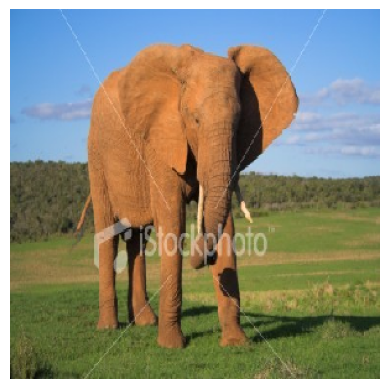

  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

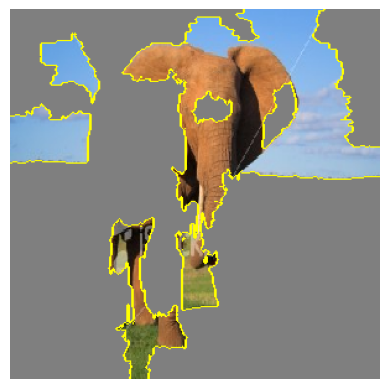

In [13]:
# set the image whose prediction is to be explained 
img_path = "/kaggle/input/lab4lime/data/African_elephant/ILSVRC2012_val_00048781.JPEG"


# Explanation parameters
top_labels        = 1 # Use top-k labels or not
hide_color        = [0,0,0] # RGB color or None (average color of superpixels is used) used to generate neighboring samples
num_lime_features = 100000 # size in number of groups of features of an explanation
num_samples       = 5000 # number of perturbated samples to generate

# Rendering parameters
positive_only   = True # display only features having a positive impact on the prediction
negative_only   = False # display only features having a negative impact on the prediction
num_superpixels = 15 # number of superpixels to display
hide_rest       = True # hide the rest of the picture or not

explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)

I0000 00:00:1728979390.708540      94 service.cc:145] XLA service 0x7899c4003900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728979390.708600      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1728979393.613031      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Top-3 predicted classes : 
	African_elephant: 0.4989873
	tusker: 0.2910453
	Indian_elephant: 0.118691914


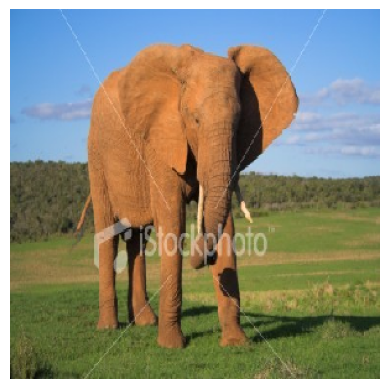

  0%|          | 0/3500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

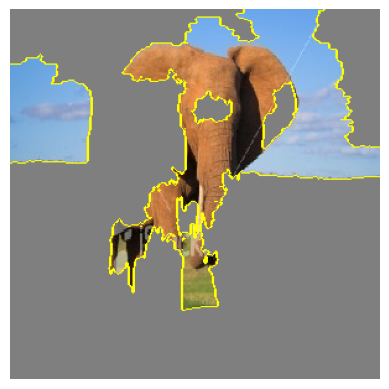

In [6]:
# set the image whose prediction is to be explained 
img_path = "/kaggle/input/lab4lime/data/African_elephant/ILSVRC2012_val_00048781.JPEG"


# Explanation parameters
top_labels        = 1 # Use top-k labels or not
hide_color        = [0,0,0] # RGB color or None (average color of superpixels is used) used to generate neighboring samples
num_lime_features = 600000 # size in number of groups of features of an explanation
num_samples       = 3500 # number of perturbated samples to generate

# Rendering parameters
positive_only   = True # display only features having a positive impact on the prediction
negative_only   = False # display only features having a negative impact on the prediction
num_superpixels = 15 # number of superpixels to display
hide_rest       = True # hide the rest of the picture or not

explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Top-3 predicted classes : 
	African_elephant: 0.4989873
	tusker: 0.2910453
	Indian_elephant: 0.118691914


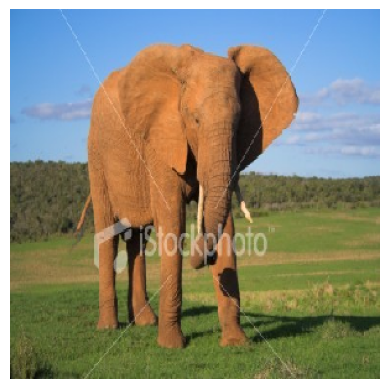

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

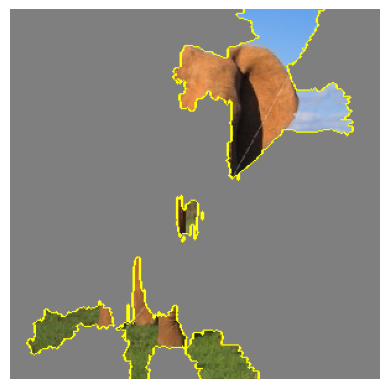

In [15]:


# LIME explanation for African Elephant with different parameters
img_path = "/kaggle/input/lab4lime/data/African_elephant/ILSVRC2012_val_00048781.JPEG"

# Experiment with different parameters for LIME
top_labels = 1  # Use top-k labels
hide_color = None  # Try setting None to let LIME average the color
num_lime_features = 100  # Number of feature groups to consider
num_samples = 3000  # Number of perturbated samples to generate

num_superpixels = 10  # Number of superpixels to display
positive_only = True  # Show positive impact features
negative_only = False  # Show negative impact features
hide_rest = True  # Hide the rest of the image

# Call the explain_with_lime function with these parameters
explain_with_lime(img_path, top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Top-3 predicted classes : 
	African_elephant: 0.4989873
	tusker: 0.2910453
	Indian_elephant: 0.118691914


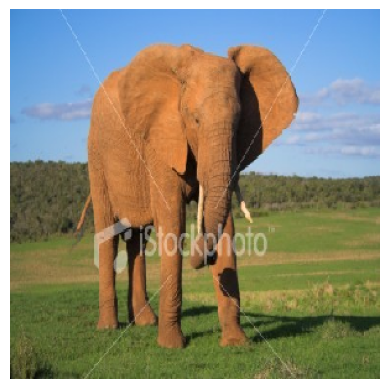

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

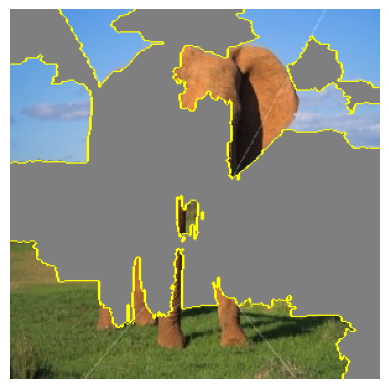

In [10]:
# Updated parameters to reduce features and increase superpixels
top_labels        = 1
hide_color        = None  # Use average color for masked regions
num_lime_features = 500  # Reduce feature groups to focus on smaller, more relevant areas
num_samples       = 3000  # Reduce perturbated samples for quicker results

# Rendering parameters
positive_only   = True
negative_only   = False
num_superpixels = 25  # Increase superpixels for finer segmentation
hide_rest       = True

# Call the explain_with_lime function
explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Top-3 predicted classes : 
	African_elephant: 0.4989873
	tusker: 0.2910453
	Indian_elephant: 0.118691914


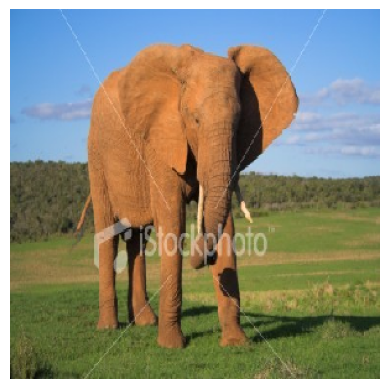

  0%|          | 0/7000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

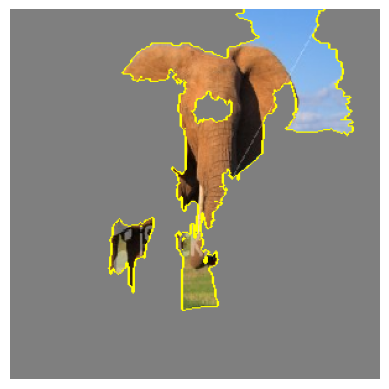

In [14]:
# Updated parameters for broader explanations
top_labels        = 1
hide_color        = [0,0,0]  # Keep the black mask for simplicity
num_lime_features = 1000  # Still keep many feature groups
num_samples       = 7000  # More perturbated samples to refine the explanation

# Rendering parameters
positive_only   = True
negative_only   = False
num_superpixels = 10  # Fewer superpixels to create a more general overview
hide_rest       = True  # Show the rest of the picture for context

# Call the explain_with_lime function
explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Top-3 predicted classes : 
	African_elephant: 0.4989873
	tusker: 0.2910453
	Indian_elephant: 0.118691914


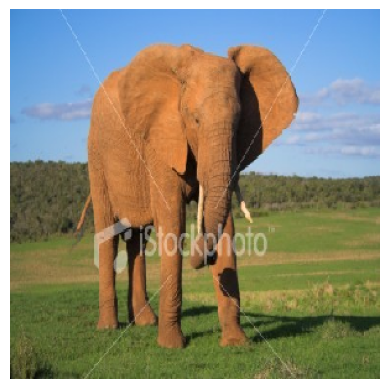

  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

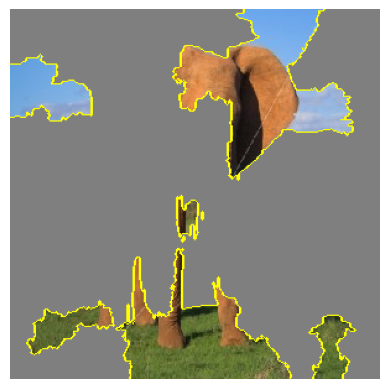

In [12]:
# Balanced parameters for both segmentation and number of features
top_labels        = 1
hide_color        = None  # Use average color for better blending with superpixels
num_lime_features = 2000  # Balanced number of features
num_samples       = 5000  # Keep the original number of perturbated samples

# Rendering parameters
positive_only   = True
negative_only   = False
num_superpixels = 15  # Keep the original number of superpixels for moderate segmentation
hide_rest       = True

# Call the explain_with_lime function
explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Top-3 predicted classes : 
	African_elephant: 0.4989873
	tusker: 0.2910453
	Indian_elephant: 0.118691914


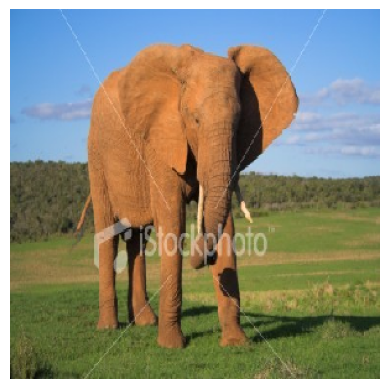

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

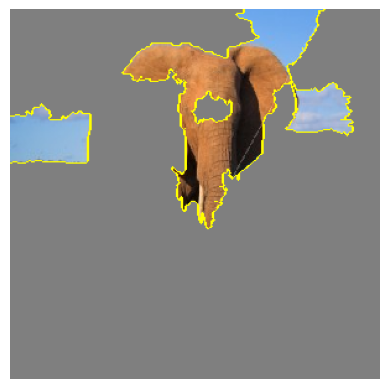

In [13]:
# Simplified parameters for quicker execution
top_labels        = 1
hide_color        = [0, 0, 0]  # Keep black mask for masked regions
num_lime_features = 500  # Small number of features for faster results
num_samples       = 2000  # Fewer perturbated samples for faster execution

# Rendering parameters
positive_only   = True
negative_only   = False
num_superpixels = 8  # Fewer superpixels for faster segmentation
hide_rest       = True

# Call the explain_with_lime function
explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Top-3 predicted classes : 
	African_elephant: 0.4989873
	tusker: 0.2910453
	Indian_elephant: 0.118691914


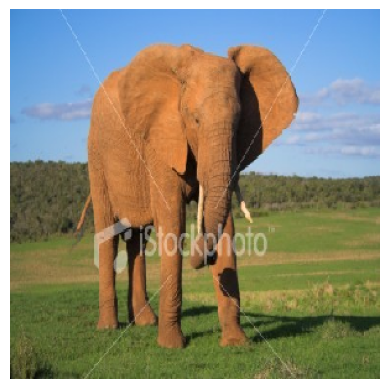

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

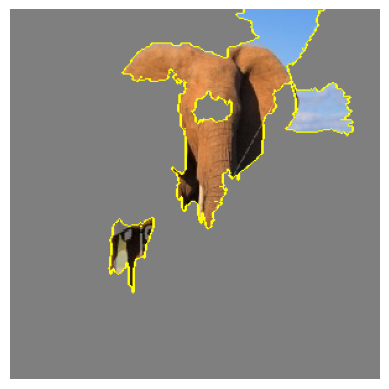

In [18]:
# Simplified parameters for quicker execution
top_labels        = 1
hide_color        = [0, 0, 0]  # Keep black mask for masked regions
num_lime_features = 100  # Small number of features for faster results
num_samples       = 3000  # Fewer perturbated samples for faster execution

# Rendering parameters
positive_only   = True
negative_only   = False
num_superpixels = 8  # Fewer superpixels for faster segmentation
hide_rest       = True

# Call the explain_with_lime function
explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)


In [ ]:
# Simplified parameters for quicker execution
top_labels        = 1
hide_color        = [0, 0, 0]  # Keep black mask for masked regions
num_lime_features = 100  # Small number of features for faster results
num_samples       = 3000  # Fewer perturbated samples for faster execution

# Rendering parameters
positive_only   = True
negative_only   = False
num_superpixels = 8  # Fewer superpixels for faster segmentation
hide_rest       = True

# Call the explain_with_lime function
explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Top-3 predicted classes : 
	African_elephant: 0.6904075
	Indian_elephant: 0.11063093
	tusker: 0.080735594


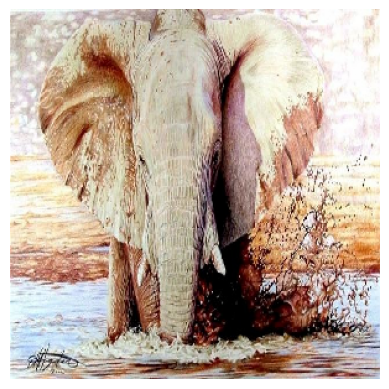

  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

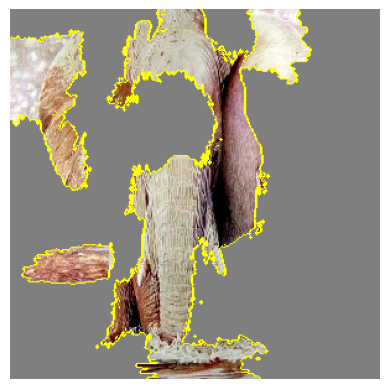

In [20]:
# set the image whose prediction is to be explained 
img_path = "/kaggle/input/lab4lime/data/African_elephant/ILSVRC2012_val_00004990.JPEG"

# Explanation parameters
top_labels        = 1 # Use top-k labels or not
hide_color        = [0,0,0] # RGB color or None (average color of superpixels is used) used to generate neighboring samples
num_lime_features = 100000 # size in number of groups of features of an explanation
num_samples       = 5000 # number of perturbated samples to generate

# Rendering parameters
positive_only   = True # display only features having a positive impact on the prediction
negative_only   = False # display only features having a negative impact on the prediction
num_superpixels = 15 # number of superpixels to display
hide_rest       = True # hide the rest of the picture or not

explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Top-3 predicted classes : 
	African_elephant: 0.6904075
	Indian_elephant: 0.11063093
	tusker: 0.080735594


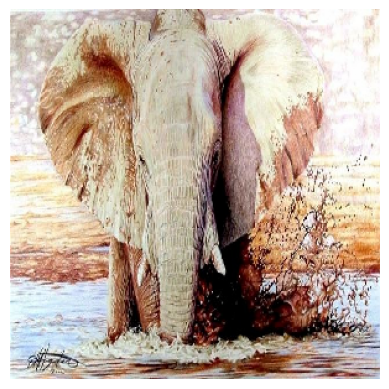

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

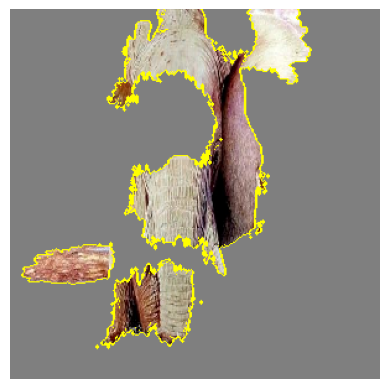

In [23]:
# LIME explanation for African Elephant with different parameters
img_path = "/kaggle/input/lab4lime/data/African_elephant/ILSVRC2012_val_00004990.JPEG"

# Experiment with different parameters for LIME
top_labels = 1  # Use top-k labels
hide_color = [0, 0, 0]  # Try setting None to let LIME average the color
num_lime_features = 100  # Number of feature groups to consider
num_samples = 3000  # Number of perturbated samples to generate

num_superpixels = 10  # Number of superpixels to display
positive_only = True  # Show positive impact features
negative_only = False  # Show negative impact features
hide_rest = True  # Hide the rest of the image

# Call the explain_with_lime function with these parameters
explain_with_lime(img_path, top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Top-3 predicted classes : 
	African_elephant: 0.40369692
	tusker: 0.34829637
	Indian_elephant: 0.03912106


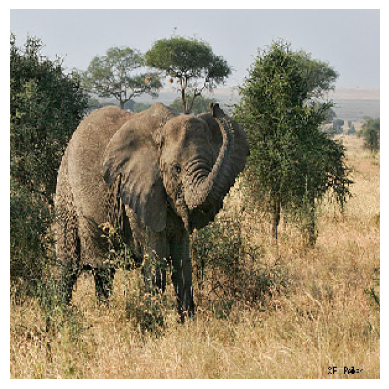

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

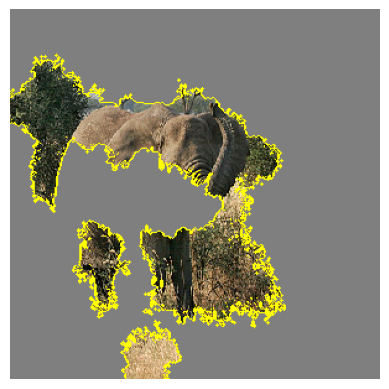

In [24]:
# LIME explanation for African Elephant with different parameters
img_path = "/kaggle/input/lab4lime/data/African_elephant/ILSVRC2012_val_00017097.JPEG"

# Experiment with different parameters for LIME
top_labels = 1  # Use top-k labels
hide_color = [0, 0, 0]  # Try setting None to let LIME average the color
num_lime_features = 100  # Number of feature groups to consider
num_samples = 3000  # Number of perturbated samples to generate

num_superpixels = 10  # Number of superpixels to display
positive_only = True  # Show positive impact features
negative_only = False  # Show negative impact features
hide_rest = True  # Hide the rest of the image

# Call the explain_with_lime function with these parameters
explain_with_lime(img_path, top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Top-3 predicted classes : 
	American_black_bear: 0.889133
	brown_bear: 0.022093013
	sloth_bear: 0.008871006


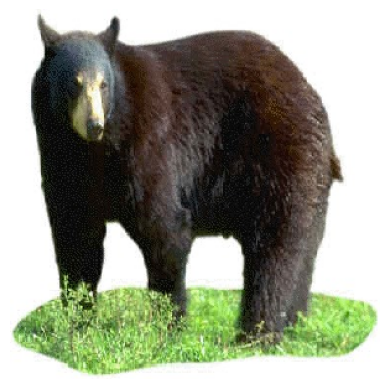

  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

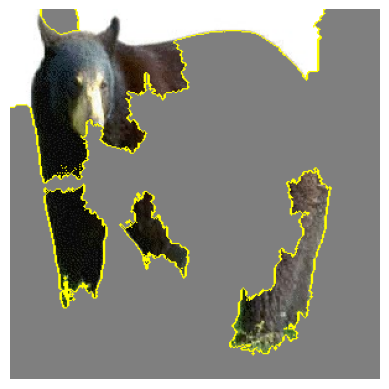

In [15]:
# set the image whose prediction is to be explained 
img_path = "/kaggle/input/lab4lime/data/black_bear/ILSVRC2012_val_00018471.JPEG"



# set the image whose prediction is to be explained 

# Explanation parameters
top_labels        = 1 # Use top-k labels or not
hide_color        = [0,0,0] # RGB color or None (average color of superpixels is used) used to generate neighboring samples
num_lime_features = 100000 # size in number of groups of features of an explanation
num_samples       = 5000 # number of perturbated samples to generate

# Rendering parameters
positive_only   = True # display only features having a positive impact on the prediction
negative_only   = False # display only features having a negative impact on the prediction
num_superpixels = 15 # number of superpixels to display
hide_rest       = True # hide the rest of the picture or not

explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Top-3 predicted classes : 
	American_black_bear: 0.889133
	brown_bear: 0.022093013
	sloth_bear: 0.008871006


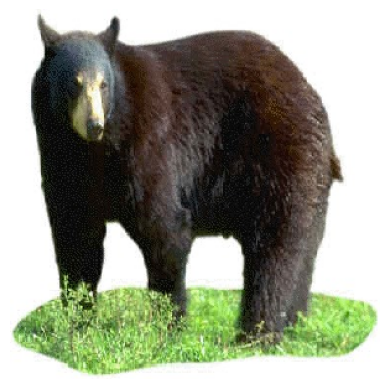

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

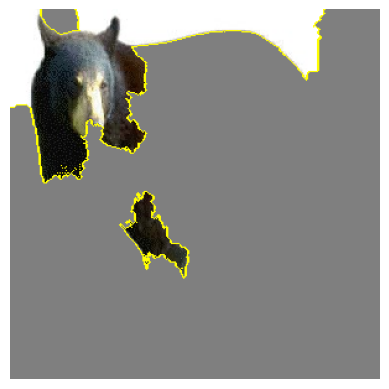

In [16]:



# set the image whose prediction is to be explained 
img_path = "/kaggle/input/lab4lime/data/black_bear/ILSVRC2012_val_00018471.JPEG"

# set the image whose prediction is to be explained 

# Explanation parameters
top_labels        = 1 # Use top-k labels or not
hide_color        = [0,0,0] # RGB color or None (average color of superpixels is used) used to generate neighboring samples
num_lime_features = 100 # size in number of groups of features of an explanation
num_samples       = 3000 # number of perturbated samples to generate

# Rendering parameters
positive_only   = True # display only features having a positive impact on the prediction
negative_only   = False # display only features having a negative impact on the prediction
num_superpixels = 10 # number of superpixels to display
hide_rest       = True # hide the rest of the picture or not

explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Top-3 predicted classes : 
	American_black_bear: 0.889133
	brown_bear: 0.022093013
	sloth_bear: 0.008871006


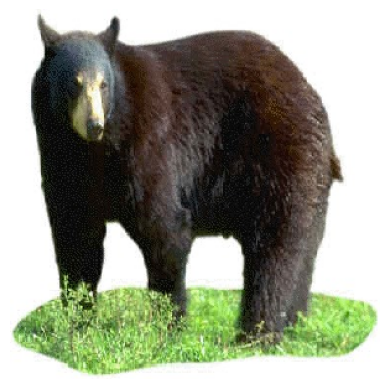

  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

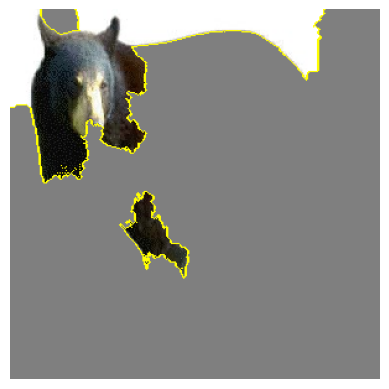

In [17]:
# set the image whose prediction is to be explained 
img_path = "/kaggle/input/lab4lime/data/black_bear/ILSVRC2012_val_00018471.JPEG"

# set the image whose prediction is to be explained 

# Explanation parameters
top_labels        = 1 # Use top-k labels or not
hide_color        = [0,0,0] # RGB color or None (average color of superpixels is used) used to generate neighboring samples
num_lime_features = 10000 # size in number of groups of features of an explanation
num_samples       = 5000 # number of perturbated samples to generate

# Rendering parameters
positive_only   = True # display only features having a positive impact on the prediction
negative_only   = False # display only features having a negative impact on the prediction
num_superpixels = 10 # number of superpixels to display
hide_rest       = True # hide the rest of the picture or not

explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)

I0000 00:00:1729123977.898425      95 service.cc:145] XLA service 0x783df80053a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729123977.898486      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1729123980.769391      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Top-3 predicted classes : 
	American_black_bear: 0.9453917
	brown_bear: 0.0031075778
	sloth_bear: 0.00092131493


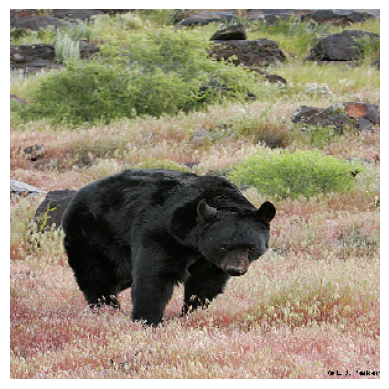

  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

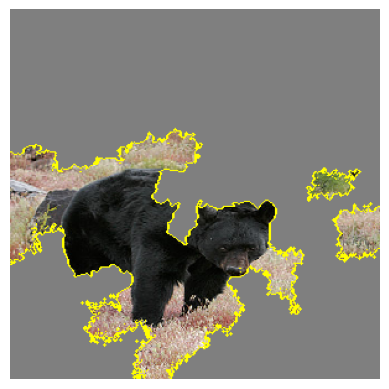

In [8]:
# set the image whose prediction is to be explained 
img_path = "/kaggle/input/lab4lime/data/black_bear/ILSVRC2012_val_00027292.JPEG"



# set the image whose prediction is to be explained 

# Explanation parameters
top_labels        = 1 # Use top-k labels or not
hide_color        = [0,0,0] # RGB color or None (average color of superpixels is used) used to generate neighboring samples
num_lime_features = 100000 # size in number of groups of features of an explanation
num_samples       = 5000 # number of perturbated samples to generate

# Rendering parameters
positive_only   = True # display only features having a positive impact on the prediction
negative_only   = False # display only features having a negative impact on the prediction
num_superpixels = 15 # number of superpixels to display
hide_rest       = True # hide the rest of the picture or not

explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Top-3 predicted classes : 
	American_black_bear: 0.9453917
	brown_bear: 0.0031075778
	sloth_bear: 0.00092131493


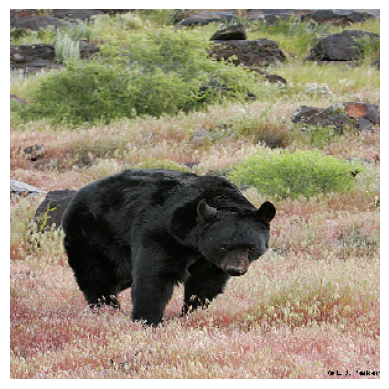

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

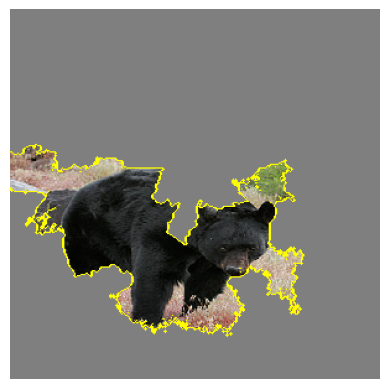

In [9]:



# set the image whose prediction is to be explained 
img_path = "/kaggle/input/lab4lime/data/black_bear/ILSVRC2012_val_00027292.JPEG"



# set the image whose prediction is to be explained 

# Explanation parameters
top_labels        = 1 # Use top-k labels or not
hide_color        = [0,0,0] # RGB color or None (average color of superpixels is used) used to generate neighboring samples
num_lime_features = 100 # size in number of groups of features of an explanation
num_samples       = 3000 # number of perturbated samples to generate

# Rendering parameters
positive_only   = True # display only features having a positive impact on the prediction
negative_only   = False # display only features having a negative impact on the prediction
num_superpixels = 10 # number of superpixels to display
hide_rest       = True # hide the rest of the picture or not

explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)

## Exercise

### Question 1
As you can see in the previous cell, many parameters have to be set manually according to the model and data. Try to identify a right combination of parameters to explain the prediction of the given image (here an african elephant). Try different values for the parameters and show which combination of the values produces the better explanation visually.
Answered in report

### Question 2
Now consider another image of african elephan (see "./data/African_elephant/"). Is your parameter setting stil appropriate? How does the output look different now?

### Question 3
We now consider images from another class to assess whether the identified setting is appropriate for another class. You can find a black bear images here: "./data/black_bear/"

What can you conclude? 

### Question 4
Here, we want to answer the following question: If we change the model, would the parameter setting still be appropriate? In other words, is the parameter setting more related to the data and tasks than it is to the model architecture?

1. Below, you can find the source code for loading a pre-trained Resnet model. Try to explain its prediction with LIME and to identify a good parameter setting.

2. What can you conclude?


### Answered in report


In [16]:
import numpy as np
import tensorflow as tf

model_builder = tf.keras.applications.resnet_v2.ResNet50V2
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
decode_predictions = tf.keras.applications.resnet_v2.decode_predictions
model = model_builder(weights="imagenet", classifier_activation="softmax")

# expected input size for ResNet50
img_size = (224,224)


In [17]:

# Function to load and preprocess image
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224 for ResNet50
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # Convert image to a float32 Numpy array
    array = tf.keras.preprocessing.image.img_to_array(img)
    # Expand array to include batch dimension
    array = np.expand_dims(array, axis=0)
    return preprocess_input(array)

# Function to make a prediction with the model
def make_prediction(img_array):
    preds = model.predict(img_array).flatten()
    pred_index = np.argmax(preds)  # Find the index of the top prediction
    labels = decode_predictions(np.asarray([preds]), top=3)[0]
    labels = [[label[1], label[2]] for label in labels]
    return preds, pred_index, labels

# Function to create a LIME explanation
def get_lime_explanation(img_array, pred_index, top_labels, hide_color, num_lime_features, num_samples):
    explainer = lime_image.LimeImageExplainer(random_state=0)  # For reproducibility
    explanation = explainer.explain_instance(
        img_array,
        model.predict,
        top_labels=top_labels,
        labels=(pred_index,),
        hide_color=hide_color,
        num_features=num_lime_features,
        num_samples=num_samples,
        random_seed=0  # For reproducibility
    )
    return explanation

In [18]:
# Function to visualize the LIME explanation
def explain_with_lime(img_path, 
                      top_labels, hide_color, num_lime_features, num_samples, # Explanation parameters
                      positive_only, negative_only, num_superpixels, hide_rest # Rendering parameters
                     ):
    img_array = get_img_array(img_path, size=img_size)
    
    # Make predictions and decode the top-3 classes
    _, pred_index, labels = make_prediction(img_array)
    
    print("Top-3 predicted classes : ")
    for l in labels:
        print("\t" + l[0] + ": " + str(l[1]))

    # Display the original image
    plt.imshow(img_array[0] / 2 + 0.5)  # Adjust for pre-processing
    plt.axis('off')
    plt.show()

    # Get LIME explanation
    explanation = get_lime_explanation(img_array[0], pred_index, top_labels, hide_color, num_lime_features, num_samples)

    # Extract explanation for the predicted class
    temp, mask = explanation.get_image_and_mask(pred_index, 
                                                positive_only=positive_only, negative_only=negative_only, 
                                                num_features=num_superpixels, hide_rest=hide_rest)

    # Display the LIME explanation with boundaries
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Top-3 predicted classes : 
	African_elephant: 0.7846675
	tusker: 0.20819598
	Indian_elephant: 0.0068448265


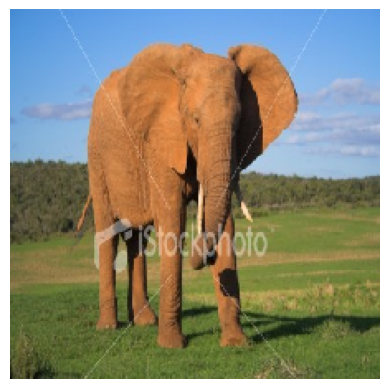

  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

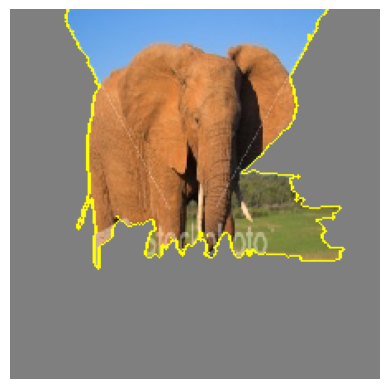

In [19]:
# set the image whose prediction is to be explained 
img_path = "/kaggle/input/lab4lime/data/African_elephant/ILSVRC2012_val_00048781.JPEG"

# img_path = "/kaggle/input/lab4lime/data/black_bear/ILSVRC2012_val_00018471.JPEG"


# Explanation parameters
top_labels        = 1 # Use top-k labels or not
hide_color        = [0,0,0] # RGB color or None (average color of superpixels is used) used to generate neighboring samples
num_lime_features = 100000 # size in number of groups of features of an explanation
num_samples       = 5000 # number of perturbated samples to generate

# Rendering parameters
positive_only   = True # display only features having a positive impact on the prediction
negative_only   = False # display only features having a negative impact on the prediction
num_superpixels = 15 # number of superpixels to display
hide_rest       = True # hide the rest of the picture or not

explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Top-3 predicted classes : 
	African_elephant: 0.7846675
	tusker: 0.20819598
	Indian_elephant: 0.0068448265


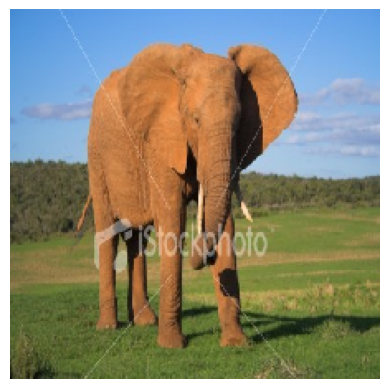

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

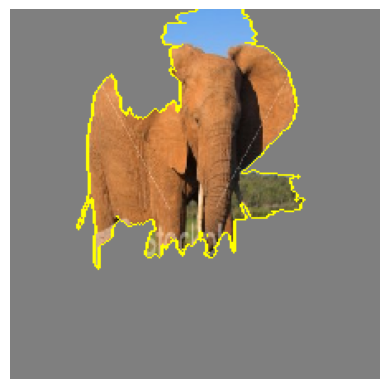

In [20]:


# Set the image whose prediction is to be explained 
img_path = "/kaggle/input/lab4lime/data/African_elephant/ILSVRC2012_val_00048781.JPEG"

# Explanation parameters
top_labels        = 1 # Use top-k labels or not
hide_color        = [0,0,0] # RGB color or None (average color of superpixels is used) used to generate neighboring samples
num_lime_features = 100 # size in number of groups of features of an explanation
num_samples       = 3000 # number of perturbated samples to generate



# Rendering parameters
positive_only   = True  # Display only features having a positive impact on the prediction
negative_only   = False  # Display only features having a negative impact on the prediction
num_superpixels = 10  # Number of superpixels to display
hide_rest       = True  # Hide the rest of the picture or not

# Call the explain_with_lime function with ResNet50V2
explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Top-3 predicted classes : 
	African_elephant: 0.7846675
	tusker: 0.20819598
	Indian_elephant: 0.0068448265


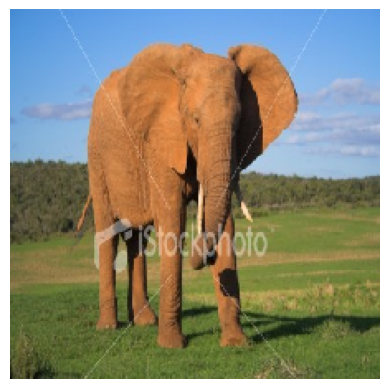

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

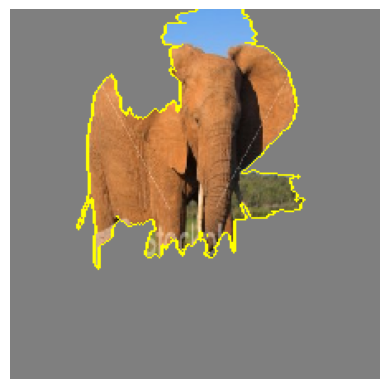

In [32]:
# Set the image whose prediction is to be explained 
img_path = "/kaggle/input/lab4lime/data/African_elephant/ILSVRC2012_val_00048781.JPEG"

# Explanation parameters
top_labels        = 1  # Use top-k labels or not
hide_color        = [0, 0, 0]  # RGB color or None (average color of superpixels is used) used to generate neighboring samples
num_lime_features = 500  # Number of feature groups for explanation
num_samples       = 3000  # Number of perturbated samples to generate

# Rendering parameters
positive_only   = True  # Display only features having a positive impact on the prediction
negative_only   = False  # Display only features having a negative impact on the prediction
num_superpixels = 10  # Number of superpixels to display
hide_rest       = True  # Hide the rest of the picture or not

# Call the explain_with_lime function with ResNet50V2
explain_with_lime(img_path, 
                  top_labels, hide_color, num_lime_features, num_samples,
                  positive_only, negative_only, num_superpixels, hide_rest)